In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

In [3]:
def lognuniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [4]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [5]:
def smdev(ys,win=3,poly=2):
    smoothed = signal.savgol_filter(ys,window_length=win,polyorder=poly)
    reldif = ((ys-smoothed)/ys)
    rmse = np.sqrt(np.mean(reldif**2))
    return rmse, reldif



def find_best_root(data,max_lig_index,target_index):
    """Returns "most reasonable" root solution from array of solutions
    based on known variables
    
    data -- the array of root solutions for a given binding equation
    max_lig_index -- length of starting ligand concentrations array
    target_index -- index of target solution in root solution tuple
    """
    holder = []
    for i in range(max_lig_index):
        temp = data[:,i,target_index]
        try:
            sp.stats.mode(temp)[0][0] > 0
            holder.append(sp.stats.mode(temp)[0][0])
        except: print('negative root encountered')
            
    result = np.array(holder)
    
    if smdev(result)[0] > 1. :
        print('Large Deviation')
        return result ,smdev(np.array(holder))[1]
        
    else:
        return result

In [6]:
def k1solv(var,parm,rtot,ltot):
    
    k1 = parm
    
    (L,R,RL) = var
    
    eq1 = R + RL - rtot
    eq2 = L + RL - ltot
    eq3 = k1 * R * L - RL
    
    return np.array([eq1,eq2,eq3])

In [7]:
lig_concs = dilser()

In [8]:
guesses = [guessgen(3) for i in range(100)]

In [9]:
res = np.array([[sp.optimize.root(k1solv,i,args=(2.0,0.1,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in guesses])

In [10]:
L = find_best_root(res,18,0)
R = find_best_root(res,18,1)
RL = find_best_root(res,18,2)

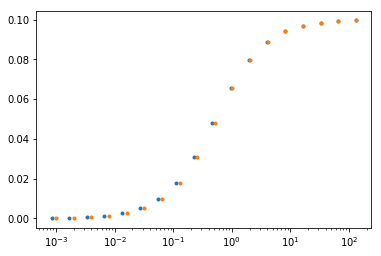

In [11]:
plt.semilogx(L,RL,'.')
plt.semilogx(lig_concs,RL,'.')

In [12]:
def k2solv(var,parm,rtot,ltot):
    
    k1 = parm[0]
    k2 = parm[1]
    
    (L,R,RL,RLL) = var
    
    eq1 = (R + RL + RLL) - rtot
    eq2 = (L + RL + 2*RLL) - ltot
    eq3 = (k1*R*L) - RL
    eq4 = (k2*k1*R*L*L) - RLL
    
    return np.array([eq1,eq2,eq3,eq4])

In [13]:
parmk2 = np.array([4.,1.])

In [14]:
k2guesses = [guessgen(4) for i in range(100)]
resk2 = np.array([[optimize.root(k2solv,i,args=(parmk2,0.1,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in k2guesses])

In [15]:
dL = find_best_root(resk2,18,0)
dR = find_best_root(resk2,18,1)
dRL = find_best_root(resk2,18,2)
dRLL = find_best_root(resk2,18,3)

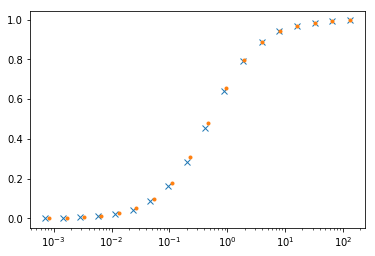

In [16]:
plt.semilogx(dL,((dRL + 2*dRLL)/(dR + dRL + dRLL))/2,'x')
plt.semilogx(L,RL/0.1,'.')

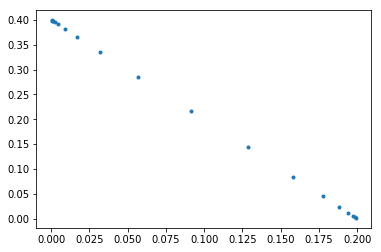

In [17]:
plt.plot((dRL + 2*dRLL),((dRL + 2*dRLL)/dL),'.')

In [18]:
def wymsol(var,parm,rtot,ltot):
    
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    (L, M, MM, ML, MML, MMLL) = var
    
    eq1 = (M + 2*MM + ML + 2*MML + 2*MMLL) - rtot
    eq2 = (L + ML + MML + 2*MMLL) - ltot
    eq3 = (l20 * M*M) - MM
    eq4 = (k11 * L * M) - ML
    eq5 = (l20 * k21 * M*M * L) - MML
    eq6 = (k22 * L * MML) - MMLL
    
    return np.array([eq1,eq2,eq3,eq4,eq5,eq6])

In [19]:
rtotwym = np.array([1e-4,1e-3,1e-2,1e-1,1e0])
parmwym = np.array([2.,4.,1.,500.])
wymguesses = [guessgen(6) for i in range(100)]

In [59]:
wymar = np.array([[[optimize.root(wymsol,i,args=(parmwym,q,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in wymguesses] for q in rtotwym])

In [60]:
wymL_0 = find_best_root(wymar[0],18,0)
wymM_0 = find_best_root(wymar[0],18,1)
wymMM_0 = find_best_root(wymar[0],18,2)
wymML_0 = find_best_root(wymar[0],18,3)
wymMML_0 = find_best_root(wymar[0],18,4)
wymMMLL_0 = find_best_root(wymar[0],18,5)

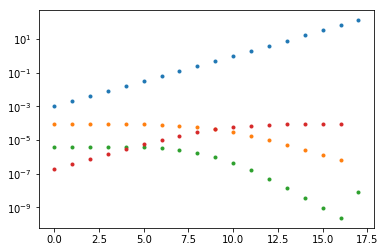

In [61]:
plt.semilogy(wymL_0,'.')
plt.semilogy(wymM_0,'.')
plt.semilogy(wymMM_0,'.') #this one
plt.semilogy(wymML_0,'.')
#plt.semilogy(wymMML_0,'.')
#plt.semilogy(wymMMLL_0,'.') #this one

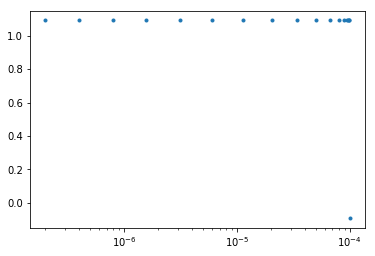

In [62]:
bound = wymML_0 + wymMML_0 + 2*wymMMLL_0

plt.semilogx(bound,(bound/wymML_0),'.')

In [63]:
smdev(wymMMLL_0)[0] < 1.

True

In [64]:
np.abs(find_best_root(wymar[0],18,0))

array([  9.99800439e-04,   1.99960167e-03,   3.99920651e-03,
         7.99842550e-03,   1.59968998e-02,   3.19939860e-02,
         6.39886543e-02,   1.27979620e-01,   2.55966141e-01,
         5.11949410e-01,   1.02393281e+00,   2.04791962e+00,
         4.09591088e+00,   8.19190575e+00,   1.63839030e+01,
         3.27679015e+01,   6.55359008e+01,   1.31071900e+02])

In [65]:
def test_rootfinder(data,max_lig_index,target_index):
    """Returns "most reasonable" root solution from array of solutions
    based on known variables
    
    data -- the array of root solutions for a given binding equation
    max_lig_index -- length of starting ligand concentrations array
    target_index -- index of target solution in root solution tuple
    """
    holder = []
    for i in range(max_lig_index):
        temp = data[:,i,target_index]
        roots,indices,counts = np.unique(temp,return_counts=True,return_index=True)
        posroots = roots[roots>0]
        posinds = indices[roots>0]
        poscounts = counts[roots>0]
        try:
            sp.stats.mode(temp)[0][0] > 0
            holder.append(sp.stats.mode(temp)[0][0])
        except: print('negative root encountered')
            
    result = np.array(holder)
            
    return result

In [66]:
test_rootfinder(wymar[0],18,5)

array([  1.67104499e-11,   6.65758683e-11,   2.64194977e-10,
         1.04020965e-09,   4.03286855e-09,   1.51760888e-08,
         5.40134379e-08,   1.74271808e-07,   4.81057460e-07,
         1.07392287e-06,   1.89429617e-06,   2.71075938e-06,
         3.33268604e-06,   3.72714663e-06,   3.95116932e-06,
         4.07083076e-06,   4.13271004e-06,   5.91284241e-04])

In [67]:
def colroots(data,max_lig_index,target_index): 
    holder = []
    for i in range(max_lig_index):
        temp = data[:,i,target_index]
        roots,counts = np.unique(temp,return_counts=True)
        posroots = roots[roots>0]
        poscounts = counts[roots>0]
        clctd = np.stack((posroots,poscounts),axis=1)
        clctd = clctd[(-1*clctd[:,1]).argsort()]
        holder.append(clctd[:,0])
    
    #firstguess = [i[1] for i in holder]
    
    return holder

In [68]:
wymar.shape

(5, 100, 18, 6)

In [69]:
wymar[0,:,0,0]

array([ 0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 , -0.50756153,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 , -0.50452761,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
       -0.50426308,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 , -0.5044493 ,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 , -0.50445661,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,  0.0009998 ,
        0.0009998 ,  0.0009998 ,  0.0009998 , -0.50431649,  0.00

In [70]:
def bag(data,rlevel,var):
    holder = []
    for i in range(18):
        temp = data[rlevel,:,i,var]
        roots,counts = np.unique(temp,return_counts=True)
        posroots = roots[roots>0]
        poscounts = counts[roots>0]
        clctd = np.stack((posroots,poscounts),axis=1)
        clctd = clctd[(-1*clctd[:,1]).argsort()]
        holder.append(clctd)
        
    return holder

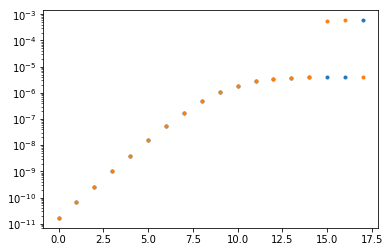

In [71]:
plt.semilogy([i[0][0] for i in bag(wymar,0,5)],'.')
plt.semilogy([i[1][0] for i in bag(wymar,0,5)],'.')

In [78]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

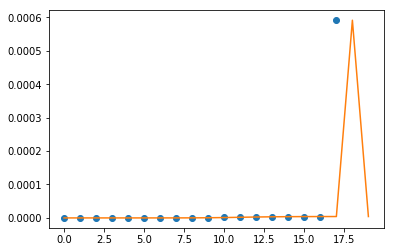

In [102]:
plt.plot(np.array([i[0][0] for i in bag(wymar,0,5)]),'o')
plt.plot(smooth(np.array([i[0][0] for i in bag(wymar,0,5)]),window_len=3),'-')

In [72]:
[i for i in bag(wymar,0,5)]

[array([[  1.67104499e-11,   5.30000000e+01],
        [  1.67104499e-11,   2.40000000e+01],
        [  1.67104499e-11,   9.00000000e+00],
        [  2.37276620e-09,   3.00000000e+00],
        [  1.67104499e-11,   1.00000000e+00],
        [  1.67104499e-11,   1.00000000e+00],
        [  2.37276620e-09,   1.00000000e+00],
        [  2.37276620e-09,   1.00000000e+00],
        [  1.77717871e+01,   1.00000000e+00],
        [  1.79833403e+01,   1.00000000e+00],
        [  1.80054057e+01,   1.00000000e+00],
        [  1.84171679e+01,   1.00000000e+00],
        [  1.85887304e+01,   1.00000000e+00],
        [  2.39421504e+01,   1.00000000e+00],
        [  2.46285153e+01,   1.00000000e+00]]),
 array([[  6.65758683e-11,   4.60000000e+01],
        [  6.65758683e-11,   2.40000000e+01],
        [  6.65758683e-11,   1.80000000e+01],
        [  9.45330444e-09,   2.00000000e+00],
        [  9.45330444e-09,   2.00000000e+00],
        [  9.45330444e-09,   1.00000000e+00],
        [  1.76577096e+01,   1.0

In [34]:
np.diff(np.log([i[0][0] for i in bag(wymar,0,5)]))

array([ 1.38230791,  1.37834521,  1.37049018,  1.35505564,  1.32524316,
        1.26951178,  1.17138333,  1.01537053,  0.80308674,  0.56752918,
        0.35838145,  0.20654979,  0.11186437,  0.0583686 ,  0.02983553,
        0.01508628,  4.96336347])

In [35]:
diffs = np.diff(np.log([i[0][0] for i in bag(wymar,0,5)]))

In [36]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [37]:
rolly = np.median(rolling_window(diffs,3),axis=1)

In [38]:
diffs_addenda = diffs.shape

In [39]:
diffmeeds = np.append(rolly[0],np.append(rolly,rolly[-1]))

In [40]:
diffmeeds.shape

(17,)

In [41]:
len([i[0][0] for i in bag(wymar,0,5)])

18

In [42]:
plt.semilogy(restest,'.')

NameError: name 'restest' is not defined

In [43]:
smdev(restest)

NameError: name 'restest' is not defined

In [44]:
a = signal.savgol_filter(restest,window_length=3,polyorder=2)

NameError: name 'restest' is not defined

In [45]:
plt.plot(np.abs(a[1:] - a[:-1]),'.')

NameError: name 'a' is not defined

In [46]:
b = np.array(restest)

NameError: name 'restest' is not defined

In [47]:
plt.plot((b[1:] - b[:1])/b[:-1])

NameError: name 'b' is not defined

In [48]:
import numpy as np

def outliers_modified_z_score(ys):
    threshold = 5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)

In [49]:
outliers_modified_z_score(((b[1:] - b[:1])/b[:-1]))

NameError: name 'b' is not defined

In [50]:
from scipy import interpolate

In [51]:
x = np.arange(len(restest))

NameError: name 'restest' is not defined

In [52]:
f = interpolate.interp1d(x,restest,kind='cubic',fill_value='extrapolate')

NameError: name 'x' is not defined

In [53]:
plt.plot(f(np.arange(20)))
plt.plot(restest,'.')

NameError: name 'f' is not defined